In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

In [64]:
import numpy as np

from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, QuantumRegister, ClassicalRegister

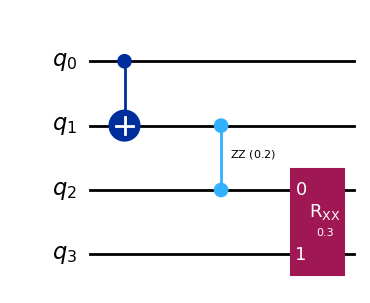

In [129]:
example_qc = QuantumCircuit(4)
example_qc.cx(0, 1)
example_qc.rzz(0.2, 1, 2)
example_qc.rxx(0.3, 2, 3)
example_qc.draw(output='mpl')

In [130]:
from qiskit import transpile
def basis_transpile(input_qc: QuantumCircuit):
    decomposed_qc = transpile(input_qc, basis_gates=['rx', 'rz', 'rxx', 'rzz'], optimization_level = 3)
    return decomposed_qc

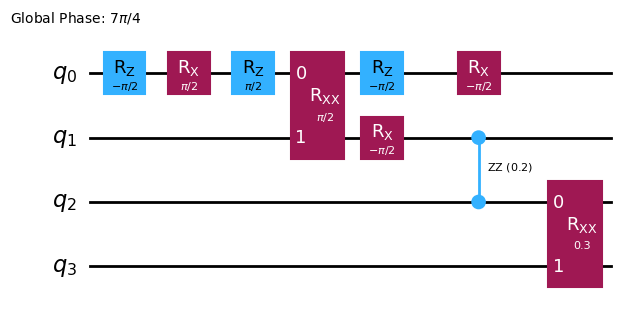

In [131]:
trans_qc = basis_transpile(example_qc)
trans_qc.draw(output = "mpl")

In [132]:
def initial_state_prep(decomposed_qc: QuantumCircuit):
    p_qr = QuantumRegister(decomposed_qc.num_qubits, name='p_qr')
    t_qr = QuantumRegister(1, name='t_qr')
    b_qr = QuantumRegister(1, name='b_qr')
    init_ancilla_qr = QuantumRegister(1, name='init_ancilla_qr')
    init_ancilla_cr = ClassicalRegister(1, name='init_ancilla_cr')
    phy_qc = QuantumCircuit(t_qr, p_qr, b_qr, init_ancilla_qr, init_ancilla_cr)

    qr_dict = {}
    qr_dict['p_qr'] = p_qr
    qr_dict['t_qr'] = t_qr
    qr_dict['b_qr'] = b_qr


    phy_qc.h(t_qr[0])
    phy_qc.cx(t_qr[0], p_qr[0])
    for i in range(0, len(p_qr) - 1):
        phy_qc.cx(p_qr[i], p_qr[i + 1])
    phy_qc.cx(p_qr[-1], b_qr[0])
    
    #add the error detection circuit:
    phy_qc.cx(b_qr[0], init_ancilla_qr[0])
    phy_qc.cx(t_qr[0], init_ancilla_qr[0])
    phy_qc.measure(init_ancilla_qr, init_ancilla_cr)
    return phy_qc, qr_dict

In [133]:
from qiskit.converters import circuit_to_dag
def logical_to_physical(decomposed_qc: QuantumCircuit, phy_qc: QuantumCircuit, qreg_dict: dict):
    DAG_rep = circuit_to_dag(decomposed_qc)
    t_qr = qreg_dict['t_qr']
    p_qr = qreg_dict['p_qr']
    b_qr = qreg_dict['b_qr']
    for node in DAG_rep.topological_op_nodes():
        print(node.name)
        #define the list of logical operations to physical operations mapping
        if node.name == 'rx':
            index = decomposed_qc.find_bit(node.qargs[0]).index
            phy_qc.rxx(node.params[0], t_qr[0], p_qr[index])
        if node.name == 'rz':
            index = decomposed_qc.find_bit(node.qargs[0]).index
            phy_qc.rzz(node.params[0], b_qr[0], p_qr[index])
        if node.name == 'rxx':
            index1 = decomposed_qc.find_bit(node.qargs[0]).index
            index2 = decomposed_qc.find_bit(node.qargs[1]).index
            phy_qc.rxx(node.params[0], p_qr[index1], p_qr[index2])
        if node.name == 'rzz':
            index1 = decomposed_qc.find_bit(node.qargs[0]).index
            index2 = decomposed_qc.find_bit(node.qargs[1]).index
            phy_qc.rzz(node.params[0], p_qr[index1], p_qr[index2])

    return phy_qc

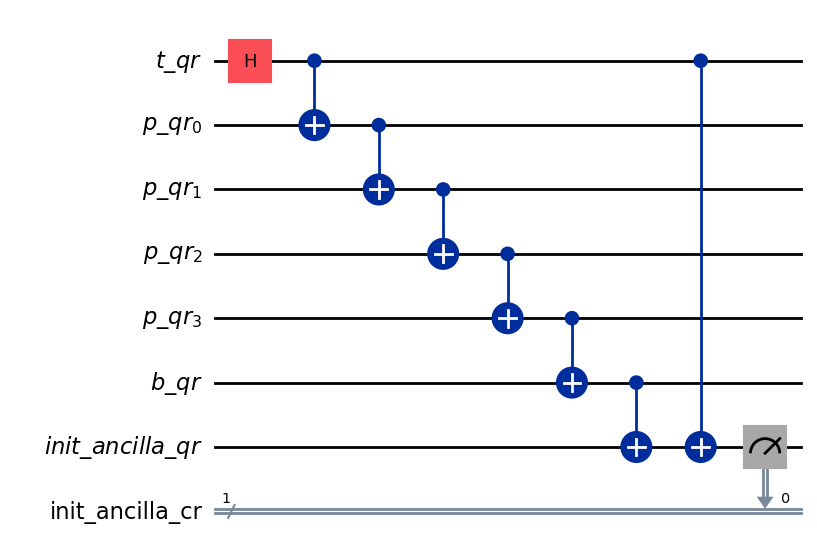

In [134]:
phy_qc, qreg_dict = initial_state_prep(trans_qc)
phy_qc.draw(output = 'mpl')

rz
rx
rz
rxx
rz
rx
rx
rzz
rxx


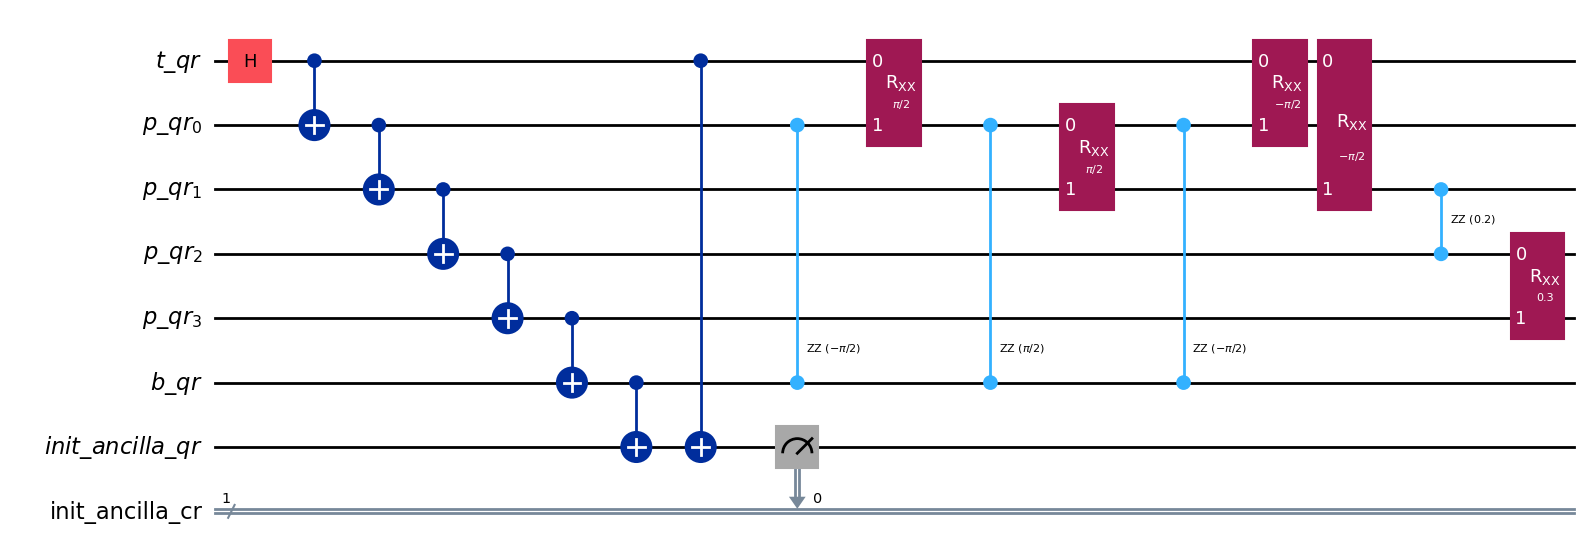

In [135]:
logical_to_physical(trans_qc, phy_qc, qreg_dict)
phy_qc.draw(output = 'mpl')

In [136]:
phy_qc.draw()

┌───┐                                              »
             t_qr: ┤ H ├──■─────────────────────────────■─────────────»
                   └───┘┌─┴─┐                           │             »
           p_qr_0: ─────┤ X ├──■────────────────────────┼───■─────────»
                        └───┘┌─┴─┐                      │   │         »
           p_qr_1: ──────────┤ X ├──■───────────────────┼───┼─────────»
                             └───┘┌─┴─┐                 │   │         »
           p_qr_2: ───────────────┤ X ├──■──────────────┼───┼─────────»
                                  └───┘┌─┴─┐            │   │         »
           p_qr_3: ────────────────────┤ X ├──■─────────┼───┼─────────»
                                       └───┘┌─┴─┐       │   │ZZ(-π/2) »
             b_qr: ─────────────────────────┤ X ├──■────┼───■─────────»
                                            └───┘┌─┴─┐┌─┴─┐    ┌─┐    »
  init_ancilla_qr: ──────────────────────────────┤ X ├┤ X ├────┤M├────»
                                                 └───┘└───┘    └╥┘    »
init_ancilla_cr: 1/═════════════════════════════════════════════╩═════»
                                                                0     »
«                   ┌───────────┐                                  »
«             t_qr: ┤0          ├──────────────────────────────────»
«                   │  Rxx(π/2) │          ┌───────────┐           »
«           p_qr_0: ┤1          ├─■────────┤0          ├─■─────────»
«                   └───────────┘ │        │  Rxx(π/2) │ │         »
«           p_qr_1: ──────────────┼────────┤1          ├─┼─────────»
«                                 │        └───────────┘ │         »
«           p_qr_2: ──────────────┼──────────────────────┼─────────»
«                                 │                      │         »
«           p_qr_3: ──────────────┼──────────────────────┼─────────»
«                                 │ZZ(π/2)               │ZZ(-π/2) »
«             b_qr: ──────────────■──────────────────────■─────────»
«                                                                  »
«  init_ancilla_qr: ───────────────────────────────────────────────»
«                                                                  »
«init_ancilla_cr: 1/═══════════════════════════════════════════════»
«                                                                  »
«                   ┌────────────┐┌────────────┐                       
«             t_qr: ┤0           ├┤0           ├───────────────────────
«                   │  Rxx(-π/2) ││            │                       
«           p_qr_0: ┤1           ├┤  Rxx(-π/2) ├───────────────────────
«                   └────────────┘│            │                       
«           p_qr_1: ──────────────┤1           ├─■─────────────────────
«                                 └────────────┘ │ZZ(0.2) ┌───────────┐
«           p_qr_2: ─────────────────────────────■────────┤0          ├
«                                                         │  Rxx(0.3) │
«           p_qr_3: ──────────────────────────────────────┤1          ├
«                                                         └───────────┘
«             b_qr: ───────────────────────────────────────────────────
«                                                                      
«  init_ancilla_qr: ───────────────────────────────────────────────────
«                                                                      
«init_ancilla_cr: 1/═══════════════════════════════════════════════════
«

In [137]:
initial_state_prep(phy_qc, qreg_dict)

TypeError: initial_state_prep() takes 1 positional argument but 2 were given

In [138]:
# def A_syndrome(phy_qc: QuantumCircuit, qreg_dict: dict, qreg: QuantumRegister):
#     phy_qc.h(qreg_dict['a2_qr'][0])
#     phy_qc.cx(qreg_dict['a2_qr'][0], qreg_dict['t_qr'][0])
#     phy_qc.cx(qreg_dict['t_qr'][0], qreg_dict['a1_qr'][0])
#     phy_qc.cx(qreg[0], qreg_dict['a1_qr'][0])
#     phy_qc.cx(qreg_dict['a2_qr'][0], qreg[0])

# def B_syndrome(phy_qc: QuantumCircuit, qreg_dict: dict, num_qubits):
#     for i in range(1, num_qubits - 1):
#         phy_qc.cx(qreg_dict['a2_qr'][0], qreg_dict['p_qr'][i])
#         phy_qc.cx(qreg_dict['p_qr'][i], qreg_dict['a1_qr'][0])

def syndrome_measurement(phy_qc: QuantumCircuit, qreg_dict: dict, num_qubits: int):
    t_qr = qreg_dict['t_qr']
    p_qr = qreg_dict['p_qr']
    b_qr = qreg_dict['b_qr']
    # Create two new ancillas
    syn_qr = QuantumRegister(2, name='syn_qr')
    syn_cr = ClassicalRegister(2, name='syn_cr')
    qreg_dict['syn_qr'] = syn_qr
    qreg_dict['syn_cr'] = syn_cr
    phy_qc.add_register(syn_qr, syn_cr)
    # A syndrome:
    phy_qc.h(syn_qr[1])
    phy_qc.cx(syn_qr[1], t_qr[0])
    phy_qc.cx(t_qr[0], syn_qr[0])
    phy_qc.cx(p_qr[0], syn_qr[0])
    phy_qc.cx(syn_qr[1], p_qr[0])
    # B syndrome
    for i in range(1, num_qubits - 1):
        phy_qc.cx(syn_qr[1], p_qr[i])
        phy_qc.cx(p_qr[i], syn_qr[0])
    # A syndrome:
    phy_qc.cx(syn_qr[1], p_qr[-1])
    phy_qc.cx(p_qr[-1], syn_qr[0])
    phy_qc.cx(b_qr[0], syn_qr[0])
    phy_qc.cx(syn_qr[1], b_qr[0])   
    phy_qc.h(syn_qr[1])
    phy_qc.measure(syn_qr, syn_cr)
    return phy_qc



In [139]:
syndrome_measurement(phy_qc, qreg_dict, trans_qc.num_qubits)

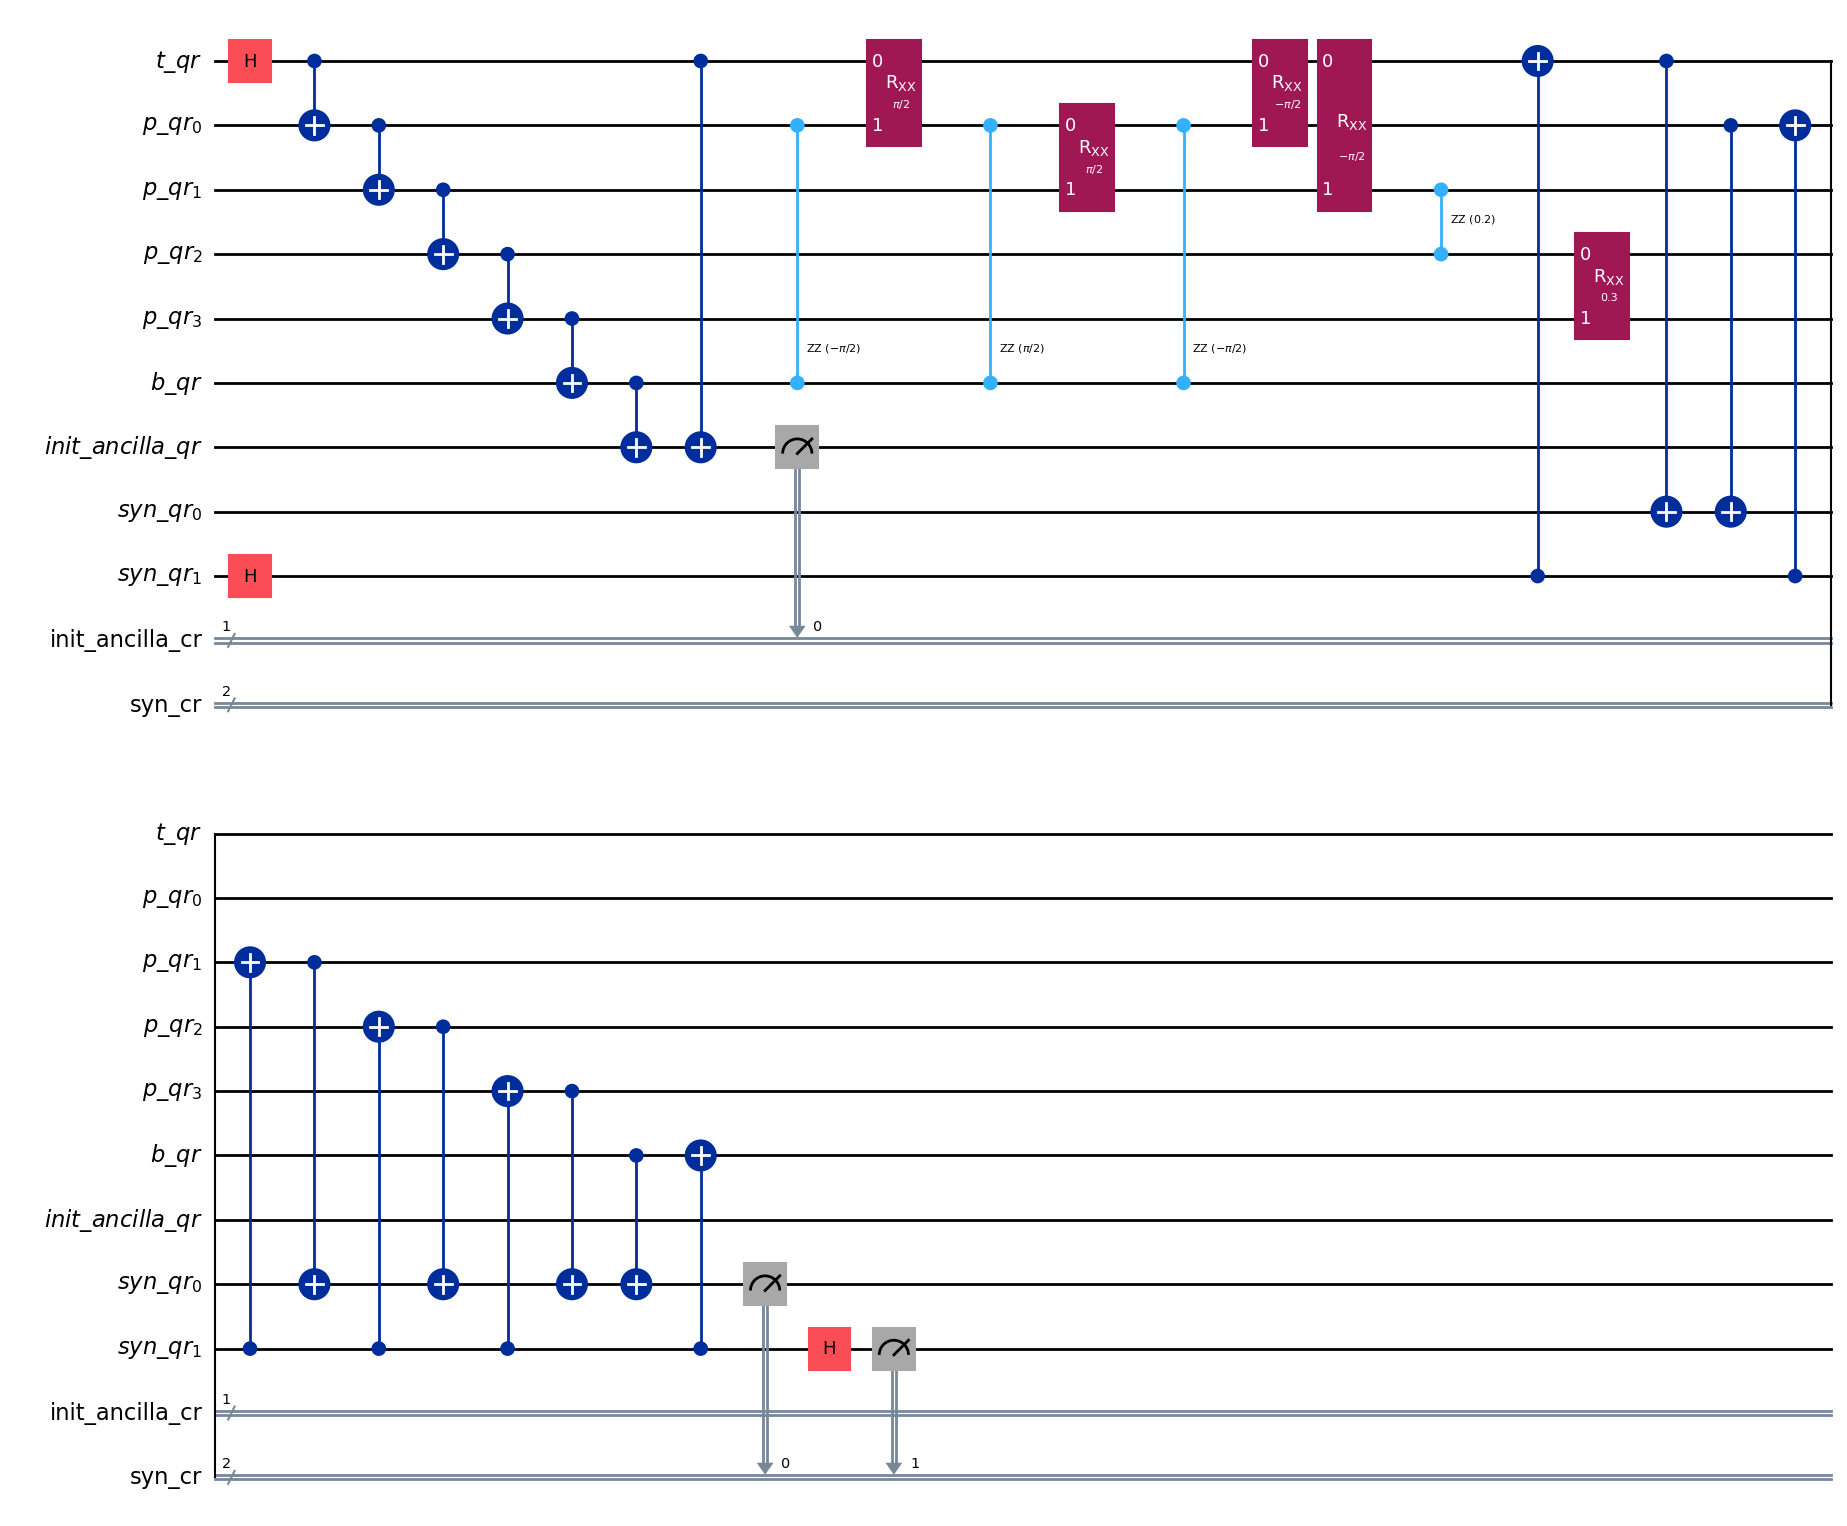

In [140]:
phy_qc.draw(output = 'mpl')

In [141]:
def measurement(phy_qc: QuantumCircuit, qreg_dict: dict, num_qubits: int):
    t_qr = qreg_dict['t_qr']
    p_qr = qreg_dict['p_qr']
    b_qr = qreg_dict['b_qr']
    # Create two new ancillas
    meas_qr = QuantumRegister(2, name='meas_qr')
    meas_cr = ClassicalRegister(2, name='meas_cr')
    qreg_dict['meas_qr'] = meas_qr
    qreg_dict['meas_cr'] = meas_cr
    phy_qc.add_register(meas_qr, meas_cr)
    phy_qc.h(meas_qr[0])
    phy_qc.cx(meas_qr[0], t_qr[0])
    phy_qc.cx(meas_qr[0], meas_qr[1])
    for i in range(0, num_qubits):
        phy_qc.cx(meas_qr[0], p_qr[i])
    phy_qc.cx(meas_qr[0], meas_qr[1])
    phy_qc.cx(meas_qr[0], b_qr[0])
    phy_qc.h(meas_qr[0])
    phy_qc.measure(meas_qr, meas_cr)
    return phy_qc


In [142]:
measurement(phy_qc, qreg_dict, trans_qc.num_qubits)

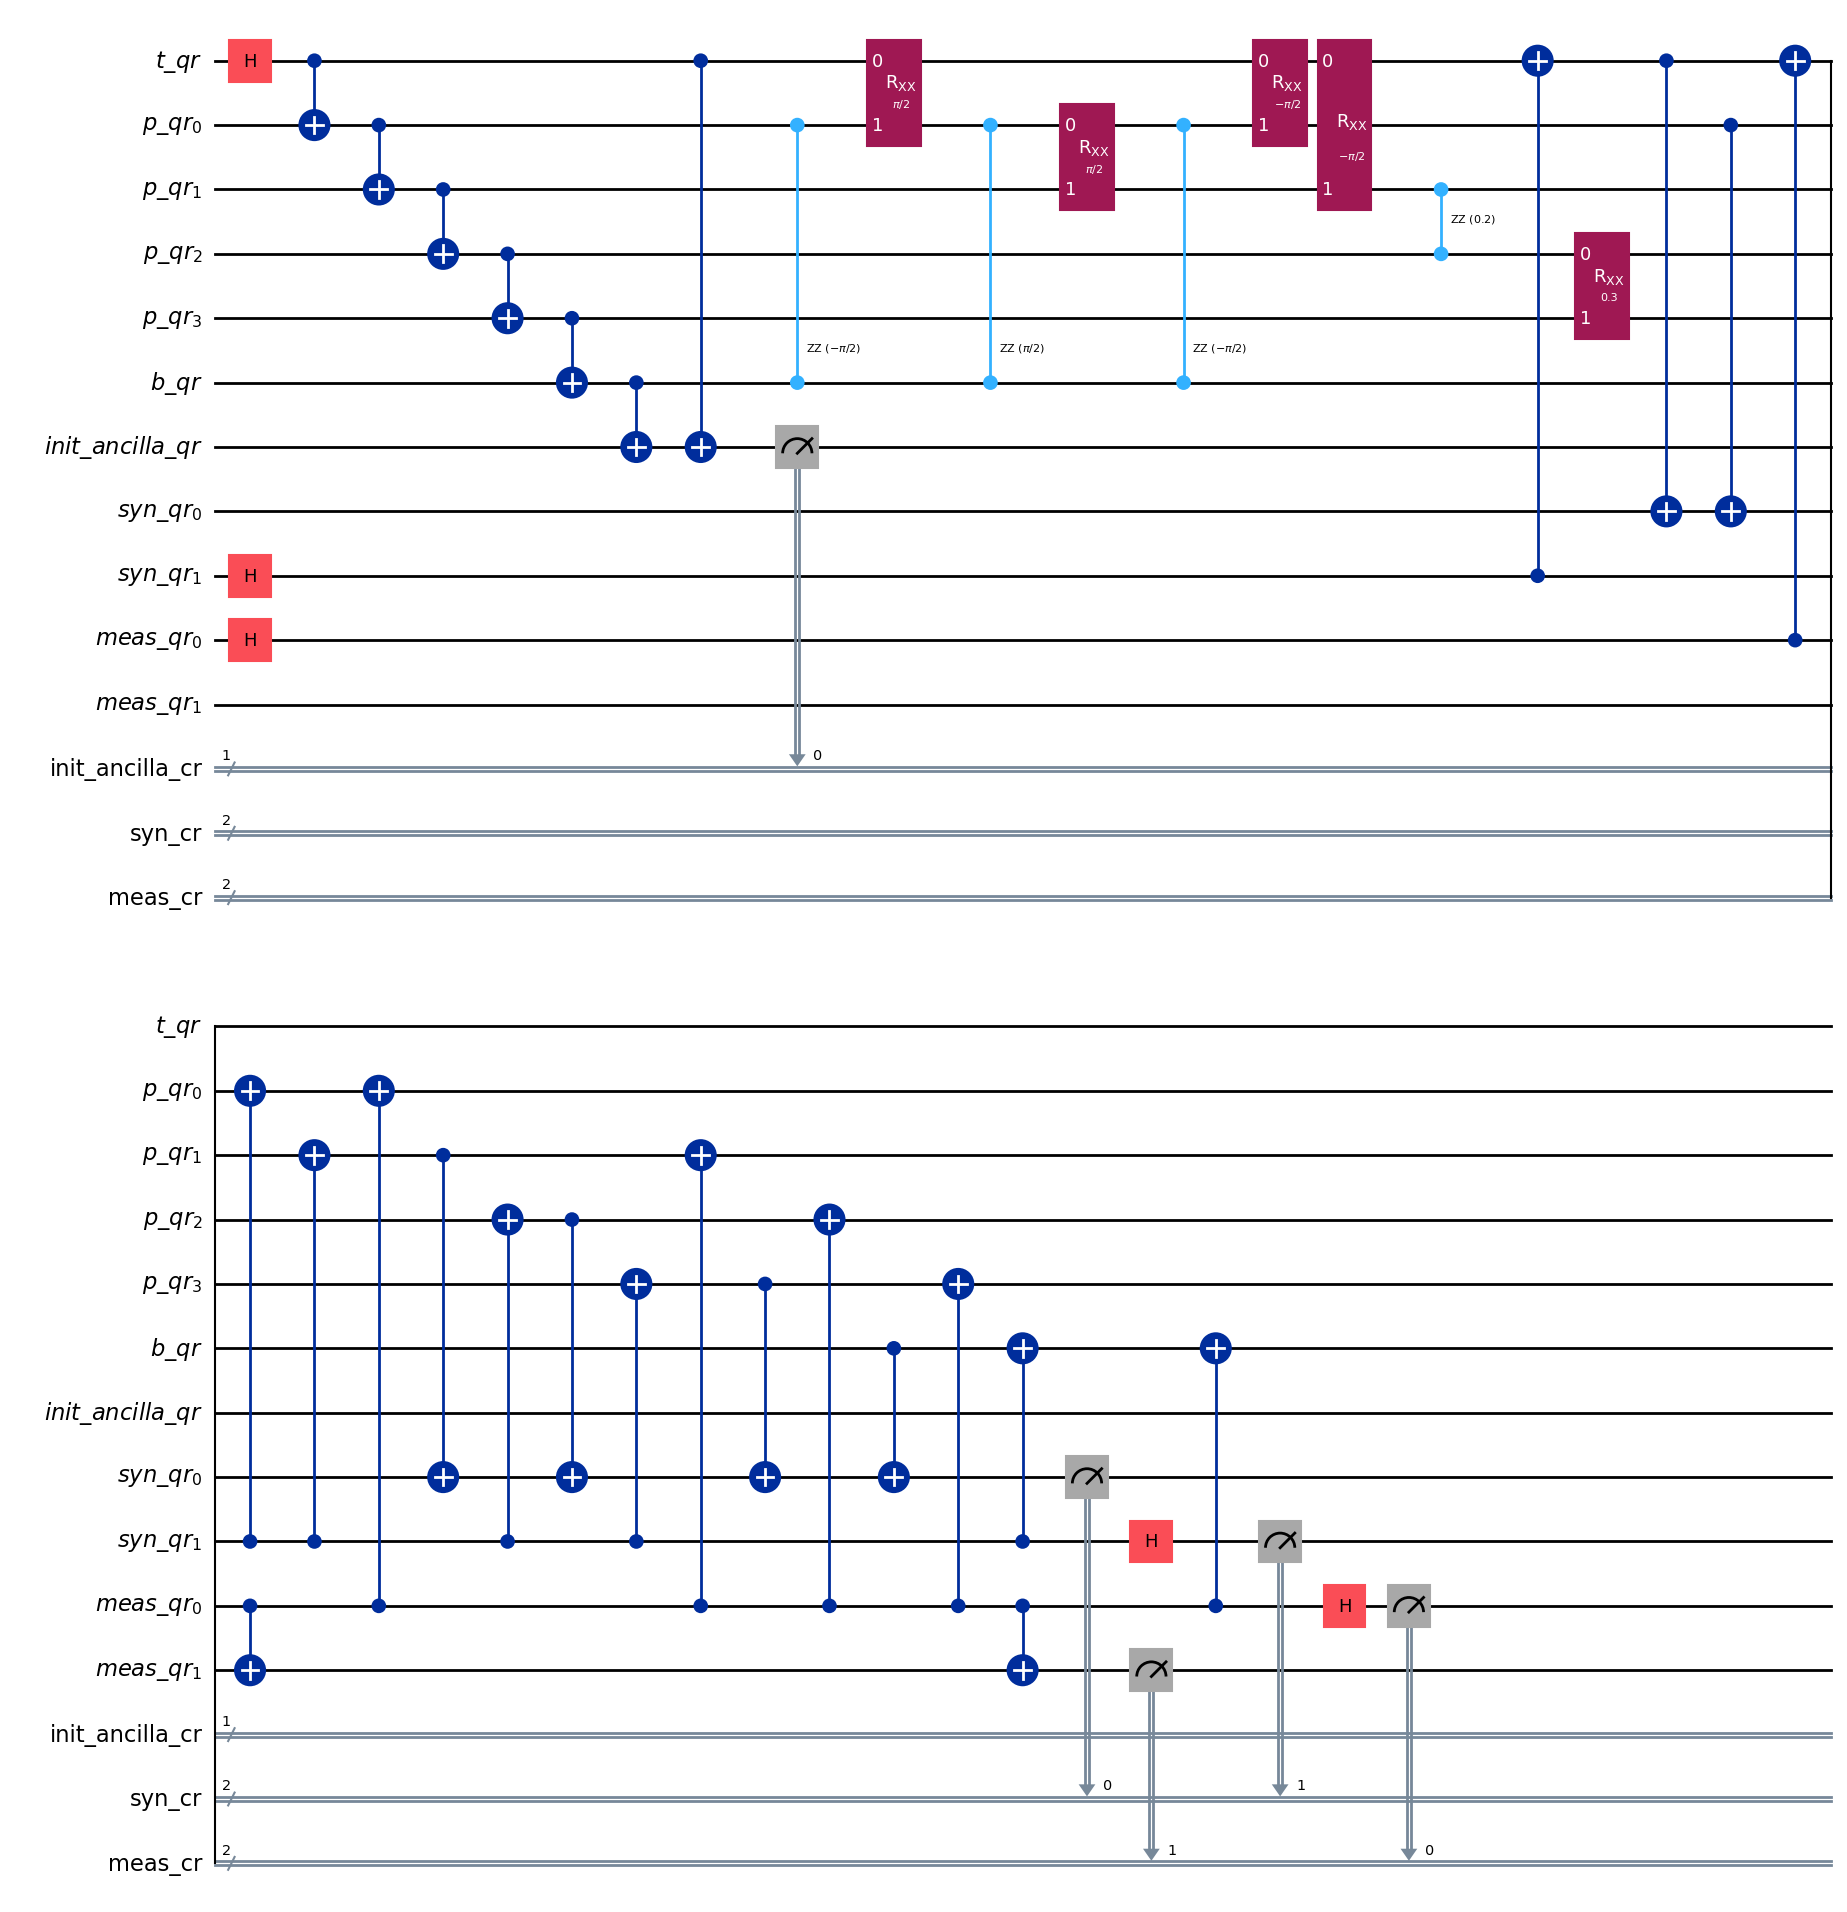

In [143]:
phy_qc.draw(output = "mpl")